## Import libraries

In [ ]:
!pip install catboost
!pip install airportsdata
!pip install pycountry

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math

from sklearn.model_selection import train_test_split

import catboost
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform, randint, uniform

from sklearn import metrics

import airportsdata, pycountry

## 1. Read and Clean Data

In [ ]:
df = pd.read_csv("AncillaryScoring_insurance.csv", encoding='latin-1')  

#Additional data
gdp_df = pd.read_csv("gdp.csv", thousands=',', encoding="unicode_escape") #https://en.wikipedia.org/wiki/List_of_countries_by_GDP_(nominal) 
gdp_capita_df = pd.read_csv("gdp_capita.csv", encoding="unicode_escape") #https://en.wikipedia.org/wiki/List_of_countries_by_GDP_(nominal)_per_capita

print(df.shape)

(50000, 15)


In [ ]:
ctry_dict = {"Myanmar (Burma)": "Myanmar",
              "Réunion": "France",
              "Timor-Leste": "East Timor",
              "Norfolk Island": "Australia",
             "Czechia":"Czech Republic",
             "Gibraltar":"United Kingdom",
             "Svalbard & Jan Mayen": "Norway"}

def geoNetwork_to_country(x):
  try:
    out = ctry_dict[x]
  except KeyError:
    out = x
  return out

df.loc[:,"geoNetwork_country"] = df.loc[:,"geoNetwork_country"].apply(geoNetwork_to_country)

In [ ]:
def format(x):
  return x.encode('utf-8').strip(b'\xc2\xa0').decode('utf-8')

gdp_df.loc[:,"Country"] = gdp_df.loc[:,"Country"].apply(format)
gdp_df.loc[:,"GDP_avg"] = gdp_df.iloc[:,1:].mean(axis=1)
gdp_df = gdp_df.drop(columns=["IMF 2022", "World Bank 2021", "United Nations 2020"])
gdp_df.head(5)

,Country,GDP_avg
0,United States,2.297500e+07
1,China,1.692602e+07
2,European Union,1.633129e+07
3,Japan,4.765267e+06
4,Germany,4.033560e+06


In [ ]:
gdp_capita_df.loc[:,"Country"] = gdp_capita_df.loc[:,"Country"].str[:-2]
gdp_capita_df.loc[:,"GDP_capita_avg"] = gdp_capita_df.iloc[:,1:].mean(axis=1)
gdp_capita_df = gdp_capita_df.drop(columns=["IMF 2022", "World Bank 2021", "United Nations 2020"])
gdp_capita_df.loc[:,"Country"] = gdp_capita_df.loc[:,"Country"].apply(format)
gdp_capita_df.head(5)

,Country,GDP_capita_avg
0,Liechtenstein,174638.000000
1,Monaco,173692.000000
2,Luxembourg,126846.000000
3,Bermuda,117407.500000
4,Ireland,95873.333333


## 2. Train-Test Split

* 20% of the dataset is sampled as the testing set and the remaining as training set. 
* Since only ~15% of the data are positive cases (buy insurance), we performed stratified sampling to maintain this proportion across the training and testing set.
* After stratified sampling, we checked whether any sampling bias is introduced in the distribution of other features.


In [ ]:
label = "INS_FLAG"
x = df.drop(columns=[label])
y = df.loc[:,label].copy() 
x_train_all, x_test_all, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0, stratify=y) 

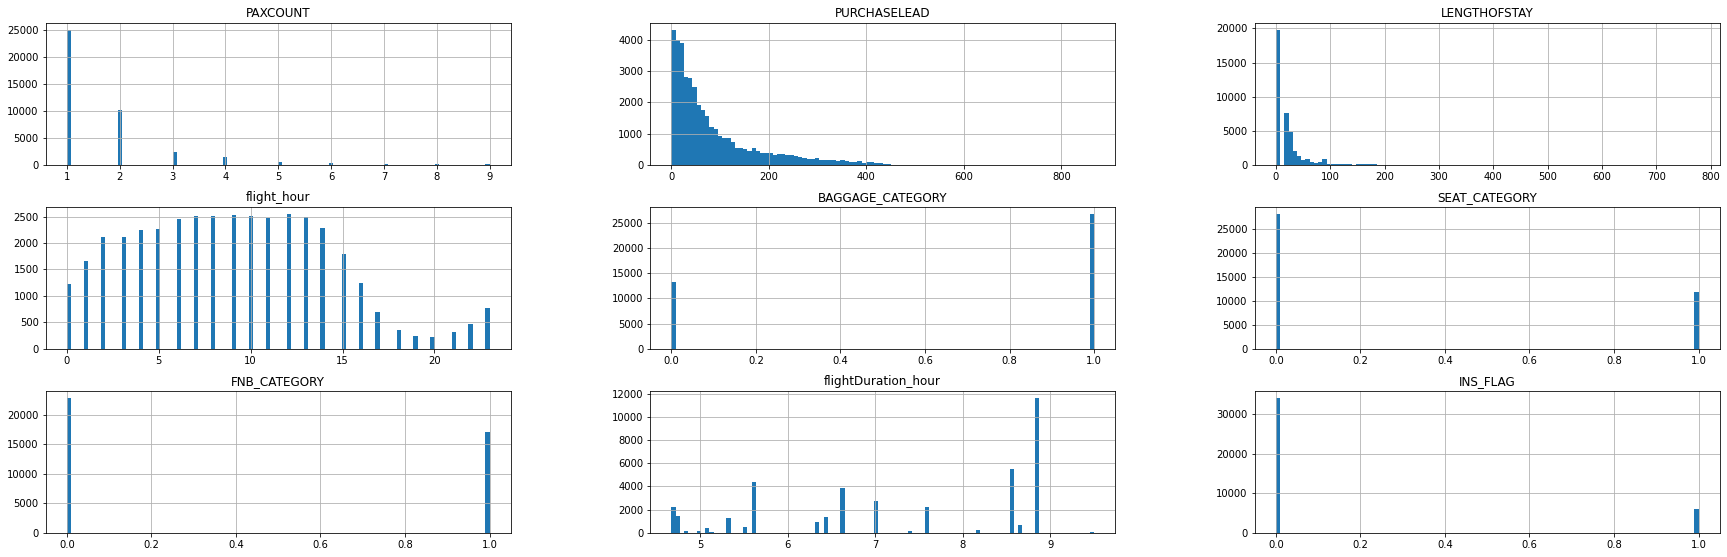

In [ ]:
#check whether partition is too different
train_set = pd.concat([x_train_all, y_train], axis=1)
train_set.iloc[:,1:].select_dtypes(include=["float64", "int64"]).hist(bins=100, figsize=(30,50), layout=(15,3)) #dont show id
plt.show()

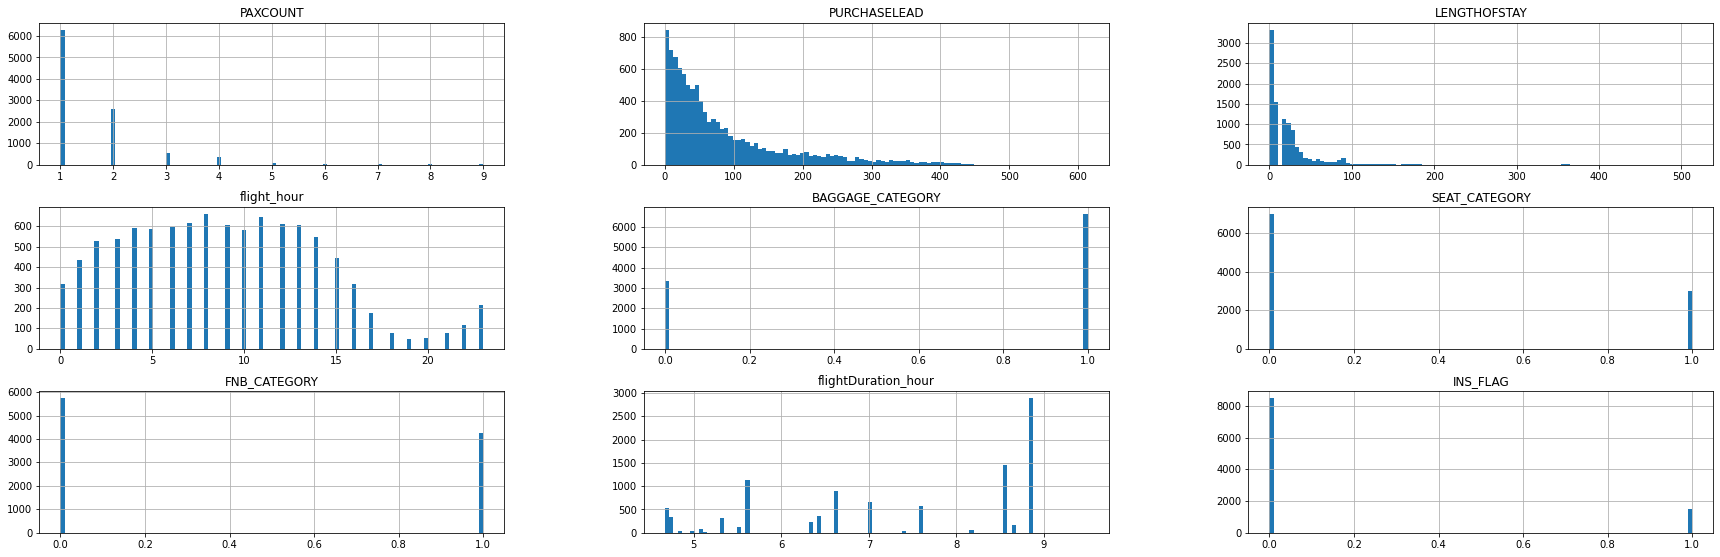

In [ ]:
test_set = pd.concat([x_test_all, y_test], axis=1)
test_set.iloc[:,1:].select_dtypes(include=["float64", "int64"]).hist(bins=100, figsize=(30,50), layout=(15,3))
plt.show()

## 3. Remove/Rescale Outliers (in train_set)

* The distribution of “PURCHASELEAD” and “LENGTHOFSTAY” appears to be a long-tailed distribution.
* Yeo-Johnson transformation is used to transform the distribution to be more normal distribution-like. For LENGTHOFSTAY, only data for one way trips (larger than zero) is transformed, as different trips represent different distributions.
* From the boxplot, “PURCHASELEAD” seems to have an outlier. This outlier is removed.


Before removing outlier:  (40000, 15)


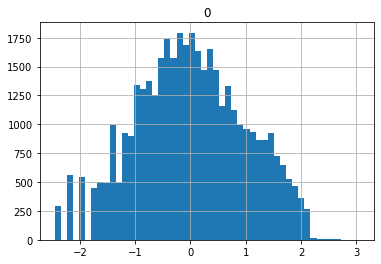

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


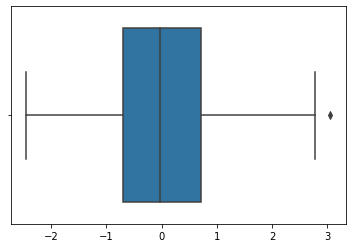

In [ ]:
#check outlier for "PURCHASELEAD"
def convert_pandas_for_cox(x):
  return x.to_numpy().reshape(x.shape[0],1)

print("Before removing outlier: ", train_set.shape)
from sklearn.preprocessing import PowerTransformer
power = PowerTransformer(method="yeo-johnson", standardize=True) #standard: mean=0, var=1
purchaselead_box = power.fit_transform(convert_pandas_for_cox(train_set.loc[:,"PURCHASELEAD"]))
pd.DataFrame(purchaselead_box).hist(bins=50)
plt.show()
sns.boxplot(purchaselead_box)
plt.show()

After removing outlier:  (39999, 15)


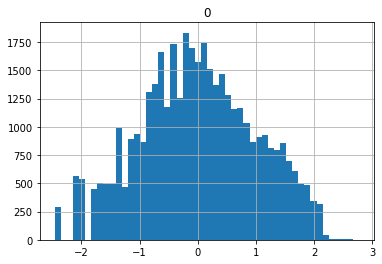

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


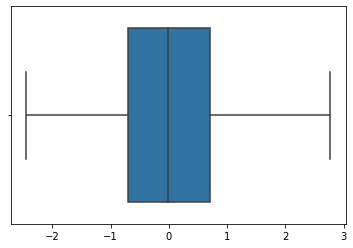

In [ ]:
#remove outlier for "PURCHASELEAD"
train_set = train_set[train_set.loc[:,"PURCHASELEAD"]<800].copy()
print("After removing outlier: ", train_set.shape)
purchaselead_box = power.fit_transform(convert_pandas_for_cox(train_set.loc[:,"PURCHASELEAD"]))
pd.DataFrame(purchaselead_box).hist(bins=50)
plt.show()
sns.boxplot(purchaselead_box)
plt.show()

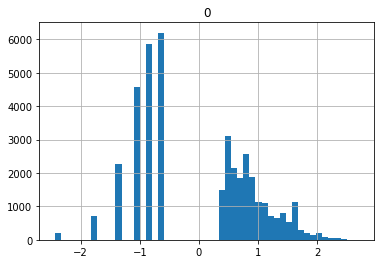

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


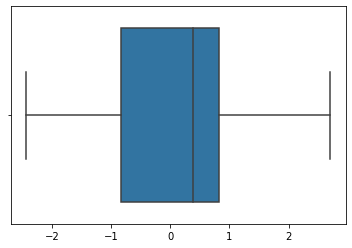

In [ ]:
lengthofstay_oneway = power.fit_transform(convert_pandas_for_cox(train_set[train_set.loc[:,"LENGTHOFSTAY"]>0].loc[:,"LENGTHOFSTAY"]))
pd.DataFrame(lengthofstay_oneway).hist(bins=50)
plt.show()
sns.boxplot(lengthofstay_oneway)
plt.show()

## 4. Feature Engineering & Encoding

Features preprocessed in this section:
* High-cardinality variables: “ROUTE” as location of airport, “geoNetwork_country” as GDP per capita
* Ordinal variables: “flight_day”


In [ ]:
airports = airportsdata.load('IATA')

def iata_to_lat(code):
  return airports[code]["lat"]
def iata_to_lon(code):
  return airports[code]["lon"]
def iata_to_elev(code):
  return airports[code]["elevation"]

def split_enc_route(df):
  ori_route = df.loc[:,"ROUTE"].str[:3]
  desti_route = df.loc[:,"ROUTE"].str[3:]

  df.loc[:,"origin_route"] = ori_route
  df.loc[:,"destination_route"] = desti_route

  df.loc[:,"ori_route_lat"] = ori_route.apply(iata_to_lat)
  df.loc[:,"ori_route_lon"] = ori_route.apply(iata_to_lon)
  df.loc[:,"ori_route_elev"] = ori_route.apply(iata_to_elev)

  df.loc[:,"desti_route_lat"] = desti_route.apply(iata_to_lat)
  df.loc[:,"desti_route_lon"] = desti_route.apply(iata_to_lon)
  df.loc[:,"desti_route_elev"] = desti_route.apply(iata_to_elev)

split_enc_route(train_set)
split_enc_route(test_set)

country_dict = {"Korea, Republic of":"South Korea", "Iran, Islamic Republic of":"Iran"}

def oriroute_to_alpha_to_country(code):
  alpha = airports[code]["country"]
  country = pycountry.countries.get(alpha_2=alpha).name
  if country in list(country_dict.keys()):
    ret = country_dict[country]
  else:
    ret = country
  return ret

def airport_to_country(df):
  df.loc[:,"ori_route_country"] = df.loc[:,"origin_route"].apply(oriroute_to_alpha_to_country)

airport_to_country(train_set)
airport_to_country(test_set)

In [ ]:
print(train_set[train_set.loc[:,"geoNetwork_country"] == train_set.loc[:,"ori_route_country"]].shape[0] *100 / train_set.shape[0])

38.67346683667092


In [ ]:
def replace_geo_nans_with_ori_route_country(df):
  df.loc[:,"geoNetwork_country"] = df.loc[:,"geoNetwork_country"].apply(lambda x : np.nan if "(not set)" in x else x)
  df.loc[:,"geoNetwork_country"].fillna(df.loc[:,"ori_route_country"], inplace=True)

replace_geo_nans_with_ori_route_country(train_set)
replace_geo_nans_with_ori_route_country(test_set)

In [ ]:
def saleschannel_to_binary(x):
  return {"Internet":1, "Mobile":0}[x]

def flight_day_to_ordinal(x):
  return {"Mon":1,"Tue":2,"Wed":3,"Thu":4,"Fri":5,"Sat":6,"Sun":7}[x]

def encode_ord(df):
  df.loc[:,"SALESCHANNEL"] = df.loc[:,"SALESCHANNEL"].apply(saleschannel_to_binary)
  df.loc[:,"flight_day"] = df.loc[:,"flight_day"].apply(flight_day_to_ordinal)

encode_ord(train_set)
encode_ord(test_set)

In [ ]:
def merge(df):
  print(df.shape)
  df = pd.merge(df, gdp_df, left_on="geoNetwork_country", right_on="Country", how="left")
  print(df.shape)
  df = pd.merge(df, gdp_capita_df, left_on="geoNetwork_country", right_on="Country", how="left")
  print(df.shape)
  df = df.drop(columns=["Country_x", "Country_y"])
  print(df.shape)
  return df

train_set = merge(train_set)
test_set = merge(test_set)

(39999, 24)
(39999, 26)
(39999, 28)
(39999, 26)
(10000, 24)
(10000, 26)
(10000, 28)
(10000, 26)


## 5. Remove/Impute missing/duplicated data

In [ ]:
def check_dups_and_nans(df):
  print("Number of duplicated rows: ", df.duplicated().sum()) 
  print("Null values: ", df.loc[df.isnull().any(axis=1)].shape[0])

check_dups_and_nans(train_set)
check_dups_and_nans(test_set)

Number of duplicated rows:  0
Null values:  0
Number of duplicated rows:  0
Null values:  0


## 6. Inspect Relationship of Features with Target Variable

In [ ]:
df_eda = train_set.copy()

GDP_capita_avg
corr = -0.22419007309426756


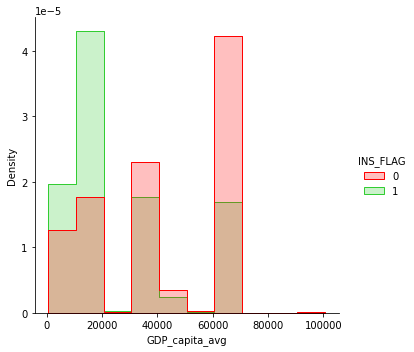

desti_route_lat
corr = 0.12235721740581391


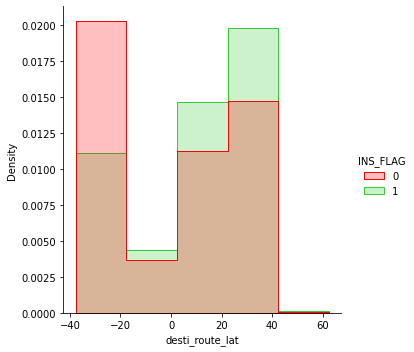

flightDuration_hour
corr = -0.11047379680803233


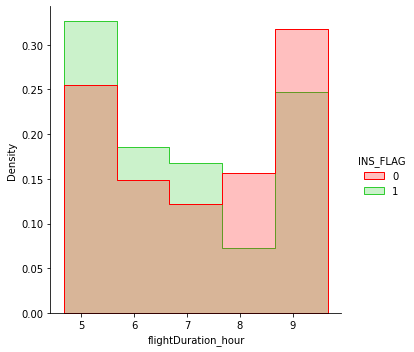

desti_route_lon
corr = -0.08781576662128461


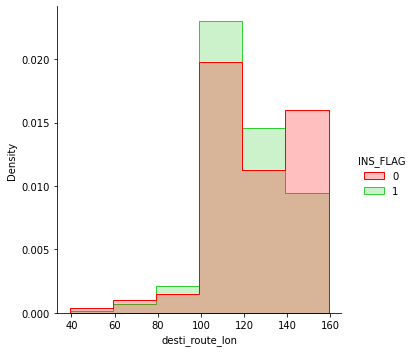

BAGGAGE_CATEGORY
corr = 0.06645930499827829


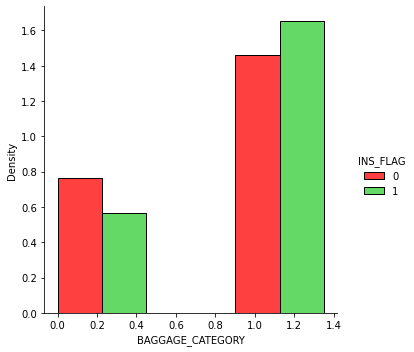

SEAT_CATEGORY
corr = 0.05140764353564578


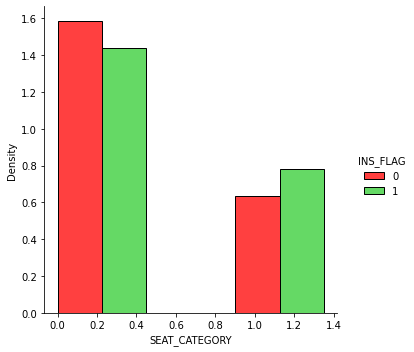

LENGTHOFSTAY
corr = -0.044662235287195776


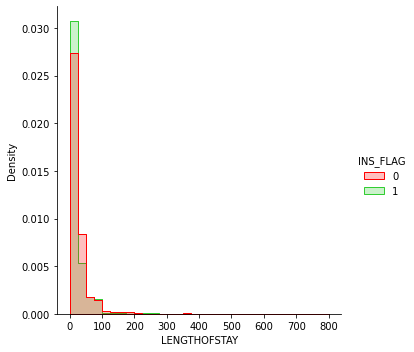

ori_route_lon
corr = 0.043596821633042744


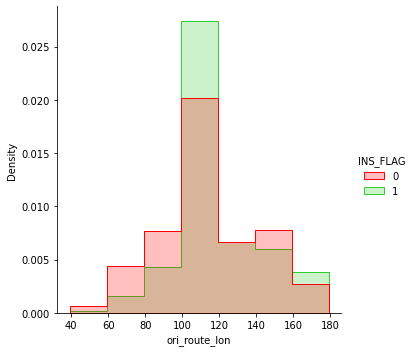

SALESCHANNEL
corr = 0.04053367146077804


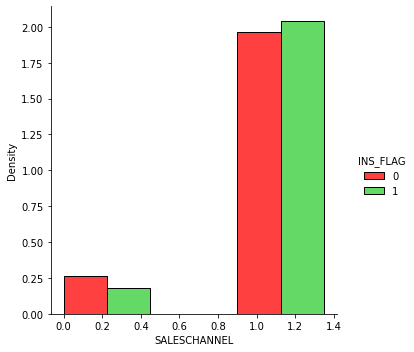

desti_route_elev
corr = 0.040209141429309356


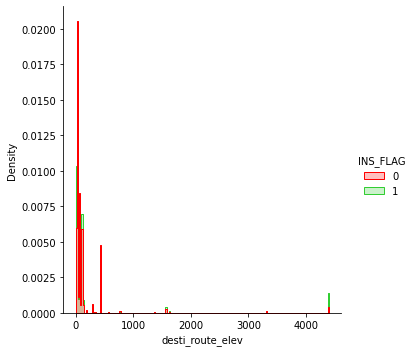

PAXCOUNT
corr = 0.027693741461873


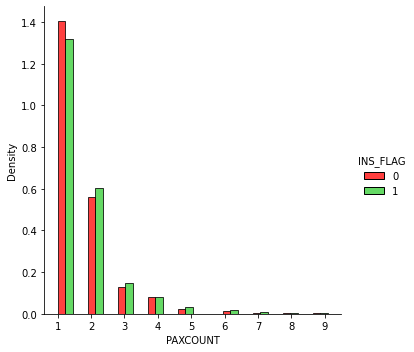

FNB_CATEGORY
corr = 0.026826323722508302


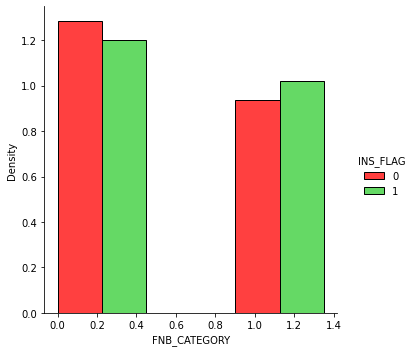

PURCHASELEAD
corr = -0.025808700006981756


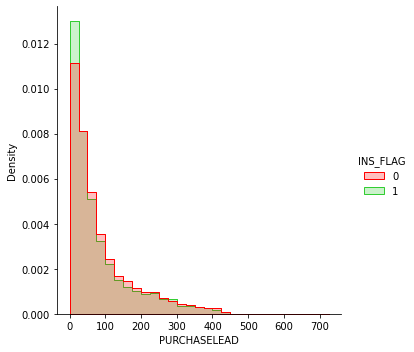

TRIPTYPEDESC_ordinal
corr = -0.02571117561392198


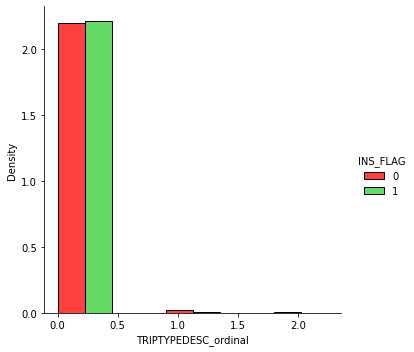

flight_hour
corr = 0.009471970545659718


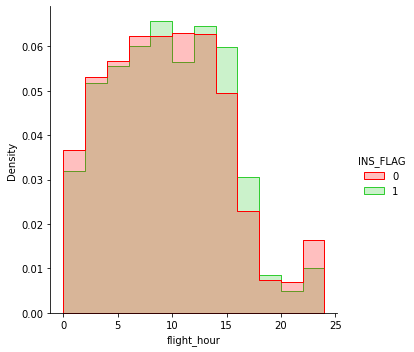

GDP_avg
corr = 0.00823409075664842


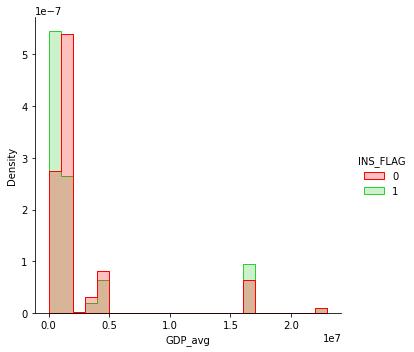

ori_route_lat
corr = 0.006825213049606822


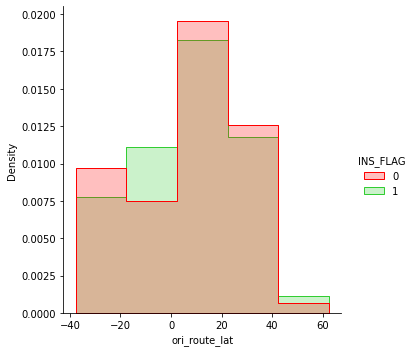

flight_day
corr = -0.006567093669528583


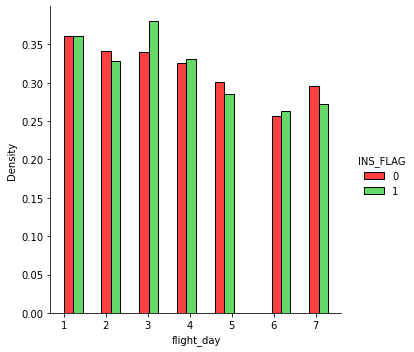

ori_route_elev
corr = -0.003739122101342775


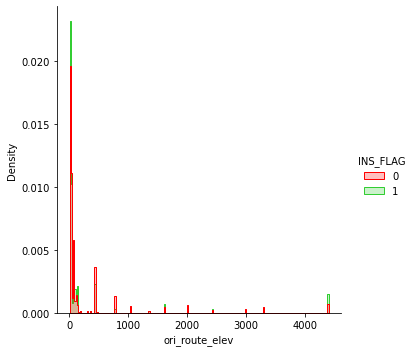

In [ ]:
def triptypedesc_to_ordinal(x):
  return {"RoundTrip":0, "OneWay":1, "CircleTrip":2}[x]
df_eda.loc[:,"TRIPTYPEDESC_ordinal"] = df_eda.loc[:,"TRIPTYPEDESC"].apply(triptypedesc_to_ordinal)


corr_matrix = df_eda.corr()
palette={0: "red", 1: "limegreen"}

def plot_histo(col, mode, binwidth=None):
  label = "INS_FLAG"
  plot_df_eda = df_eda.loc[:,[col, label]]
  try:
    print("corr =", corr_matrix.loc[col, label])
  except KeyError:
    pass
  if mode=="cat":
    binwidth = 0.45 if not binwidth else binwidth
    sns.displot(plot_df_eda, x=col, hue=label, multiple="dodge", binwidth=binwidth, stat="density", common_norm=False, palette=palette)
  elif mode=="conti":
    binwidth = 0.05 if not binwidth else binwidth
    sns.displot(plot_df_eda, x=col, hue=label, element="step", binwidth=binwidth, stat="density", common_norm=False, palette=palette)
  plt.show()


label_lst = [label]
drop_col_lst = ["Id"]
added_col_lst = ["origin_route", "destination_route", "target_weight"]
cat_cardi_lst = ["ROUTE", "geoNetwork_country", "TRIPTYPEDESC"]
cat_lst = ["PAXCOUNT", "SALESCHANNEL", "TRIPTYPEDESC_ordinal", "flight_day",
           "BAGGAGE_CATEGORY", "SEAT_CATEGORY", "FNB_CATEGORY"]

for col in df_eda.corr().loc[:, "INS_FLAG"].abs().sort_values(ascending=False).index.to_list():
  if col in list(set(df_eda.columns.tolist()) - set(label_lst) - set(drop_col_lst) - set(added_col_lst) - set(cat_cardi_lst)):
    print(col)
    mode = "cat" if col in cat_lst else "conti"
    if col in ["PURCHASELEAD", "LENGTHOFSTAY"]:
      binwidth = 25
    elif "route" in col:
      binwidth = 20
    elif col in ["flight_hour"]:
      binwidth = 2
    elif col in ["flightDuration_hour"]:
      binwidth = 1
    elif col in ["GDP_avg"]:
      binwidth = 1000000
    elif col in ["GDP_capita_avg"]:
      binwidth = 10000
    else: 
      binwidth = None
    plot_histo(col, mode, binwidth)
  else:
    continue


## 7. Model Training and Evaluation
* The CatBoost model is used as it performs well on tabular data and addresses categorical variables using a mixed strategy of one-hot encoding and target encoding.
* The Logloss loss function is used as we formulated our problem as a binary classification problem.
* Steps taken to address imbalanced dataset (only ~15% of data are positives):
** Rebalance the class weights based on the positive’s distribution
** Use F1 score as the evaluation metric to balance precision and recall for the positive
* Hyperparameter tuning is done using 5-fold cross validation.


In [ ]:
train_set.columns

Index(['Id', 'PAXCOUNT', 'SALESCHANNEL', 'TRIPTYPEDESC', 'PURCHASELEAD',
       'LENGTHOFSTAY', 'flight_hour', 'flight_day', 'ROUTE',
       'geoNetwork_country', 'BAGGAGE_CATEGORY', 'SEAT_CATEGORY',
       'FNB_CATEGORY', 'flightDuration_hour', 'INS_FLAG', 'origin_route',
       'destination_route', 'ori_route_lat', 'ori_route_lon', 'ori_route_elev',
       'desti_route_lat', 'desti_route_lon', 'desti_route_elev',
       'ori_route_country', 'GDP_avg', 'GDP_capita_avg'],
      dtype='object')

In [ ]:
cat_feat = ["TRIPTYPEDESC"]

def feat_target_split_drop(df):
  x = df.drop(columns=[label, "Id", "ROUTE", "geoNetwork_country", "origin_route", "destination_route", 'ori_route_country', 'GDP_avg'])
  y = df.loc[:,label].copy() 
  return x, y

x_train, y_train = feat_target_split_drop(train_set)
x_test, y_test = feat_target_split_drop(test_set)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(39999, 18) (39999,)
(10000, 18) (10000,)


In [ ]:
zero_weight = y_train.value_counts().loc[1] / y_train.shape[0]
one_weight = y_train.value_counts().loc[0] / y_train.shape[0]

def target_to_weight(x): 
  return {0:zero_weight, 1:one_weight}[x]  

print(target_to_weight(0), target_to_weight(1))

In [ ]:
catb_clf = catboost.CatBoostClassifier(loss_function="Logloss", 
                                       random_state=42, cat_features=cat_feat, thread_count=-1,
                                       class_weights={0: target_to_weight(0), 1: target_to_weight(1)})

eval_scoring = "f1"
catb_params_distribs = {
  "iterations": randint(low=10,high=1000),
  "depth": randint(low=1,high=8),
  "learning_rate": loguniform(0.01, 1.0),

  "bagging_temperature": uniform(loc=0.0,scale=1.0-0.0),
  "border_count": randint(low=1,high=255),
  "l2_leaf_reg": randint(low=2,high=30),
}

catb_rand_cv = RandomizedSearchCV(estimator=catb_clf, 
                                   param_distributions=catb_params_distribs, 
                                   n_iter=20, cv=5, verbose=2, #highest verbose
                                   random_state=42, n_jobs=-1,
                                  scoring=eval_scoring)
catb_rand_cv.fit(x_train, y_train)

In [ ]:
catb_rand_cv.best_params_

{'bagging_temperature': 0.1959828624191452,
 'border_count': 249,
 'depth': 6,
 'iterations': 305,
 'l2_leaf_reg': 22,
 'learning_rate': 0.05989003672254299}

In [ ]:
best_params = {'bagging_temperature': [0.1959828624191452],
 'border_count': [249],
 'depth': [6],
 'iterations': [305],
 'l2_leaf_reg': [22],
 'learning_rate':[0.05989003672254299]}

catb_rand_cv = RandomizedSearchCV(estimator=catb_clf, 
                                   param_distributions=best_params, 
                                   n_iter=1, cv=5, verbose=2, #highest verbose
                                   random_state=42, n_jobs=-1, return_train_score=True,
                                   scoring=eval_scoring, refit=True)
catb_rand_cv.fit(x_train, y_train)

In [77]:
best_model = catb_rand_cv.best_estimator_
best_model

In [78]:
cv_results_final = pd.DataFrame(catb_rand_cv.cv_results_)
cv_results_final

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_l2_leaf_reg,param_iterations,param_depth,param_border_count,param_bagging_temperature,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,13.920963,2.940071,0.022856,0.007757,0.05989,22,305,6,249,0.195983,...,0.437393,0.005749,1,0.477142,0.471995,0.47377,0.47257,0.474071,0.47391,0.001786


In [79]:
y_train_pred_proba = catb_rand_cv.predict_proba(x_train)
print("train_loss\t\t\t = ", metrics.log_loss(y_train, y_train_pred_proba))
print("cv_mean_train_score\t\t = ", cv_results_final.loc[0,"mean_train_score"])
print("cv_mean_test_score (eval)\t = ", cv_results_final.loc[0,"mean_test_score"])

train_loss			 =  0.5166085693941771
cv_mean_train_score		 =  0.47390958570154923
cv_mean_test_score (eval)	 =  0.43739289715232654


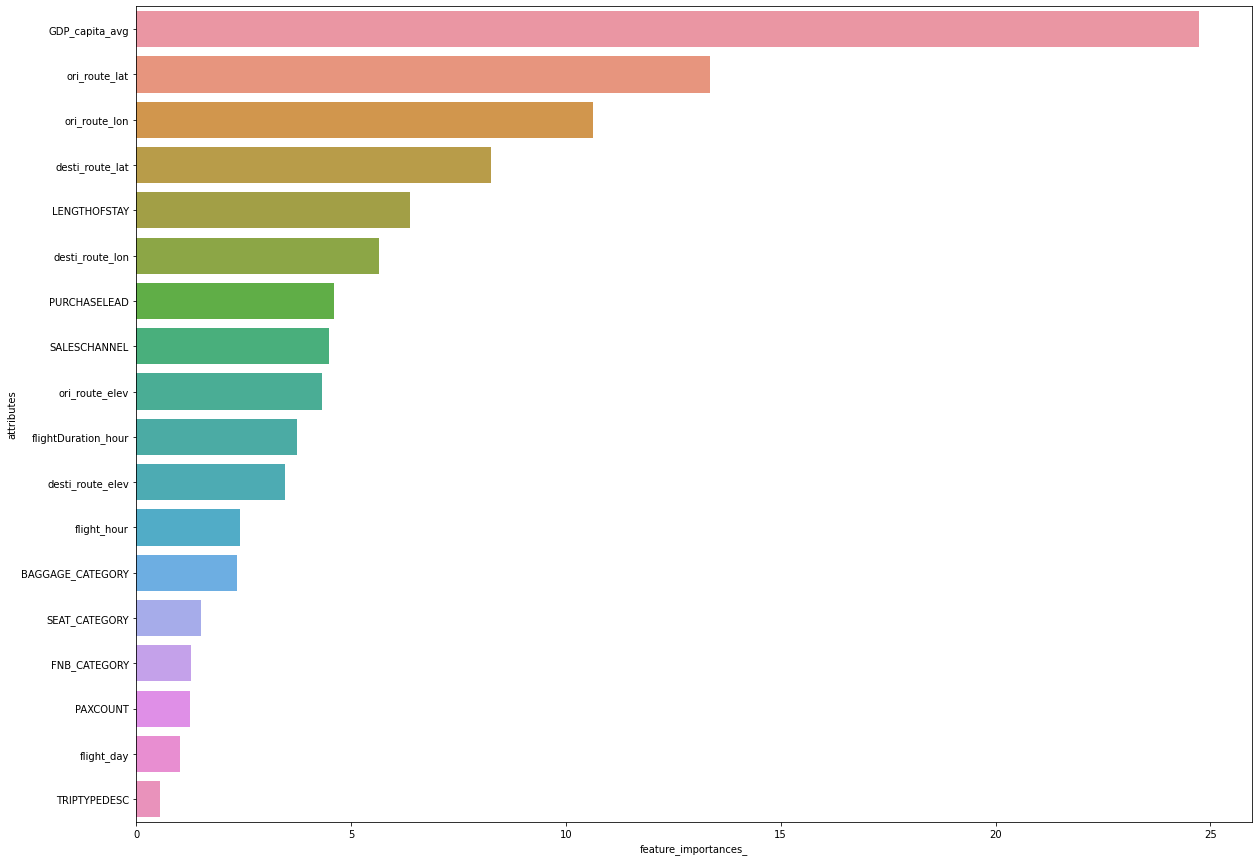

In [80]:
feat_importance = pd.DataFrame({"feature_importances_": best_model.feature_importances_,
                                "attributes": x_train.columns.tolist()})
feat_importance = feat_importance.sort_values("feature_importances_", ascending=False)

plt.figure(figsize = (20, 15))
sns.barplot(x = feat_importance.loc[:,"feature_importances_"], 
            y = feat_importance.loc[:,"attributes"])
plt.show()

## 8. Model Testing

test_loss	=  0.530758882670389
Acc		=  71.62 %
Precison	=  31.26 %
Recall		=  74.8 %
F1		=  44.09 %
ROC_AUC		=  0.7293




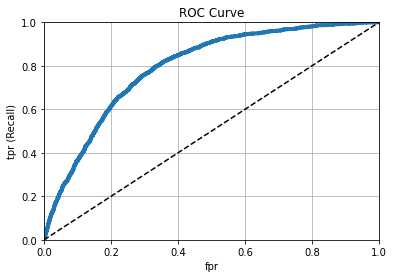

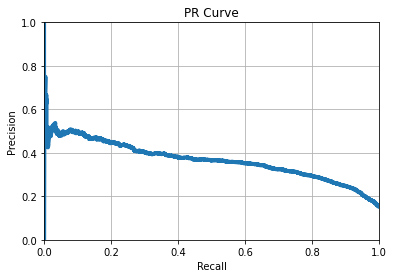

In [82]:
y_test_pred = best_model.predict(x_test)
y_test_pred_proba = best_model.predict_proba(x_test)

test_loss = metrics.log_loss(y_test, y_test_pred_proba)
accuracy = metrics.accuracy_score(y_test, y_test_pred)
precision = metrics.precision_score(y_test, y_test_pred)
recall = metrics.recall_score(y_test, y_test_pred)
f1 = metrics.f1_score(y_test, y_test_pred)
roc_auc = metrics.roc_auc_score(y_test, y_test_pred)

print("test_loss\t= ", test_loss)
print("Acc\t\t= ", round(accuracy * 100, 2), "%")
print("Precison\t= ", round(precision * 100, 2), "%")
print("Recall\t\t= ", round(recall * 100, 2), "%")
print("F1\t\t= ", round(f1 * 100, 2), "%")
print("ROC_AUC\t\t= ", round(roc_auc, 4)) #perfect = 1
print("\n")

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_pred_proba[:,1])
plt.plot(fpr, tpr, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1]) 
plt.title("ROC Curve")                                   
plt.xlabel("fpr") 
plt.ylabel("tpr (Recall)")    
plt.grid(True)                                            
plt.show()

precisions, recalls, thresholds = metrics.precision_recall_curve(y_test, y_test_pred_proba[:,1])
plt.plot(recalls, precisions, linewidth=4)
plt.axis([0, 1, 0, 1])
plt.title("PR Curve")  
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.show()

#train_loss = 0.5166085693941771

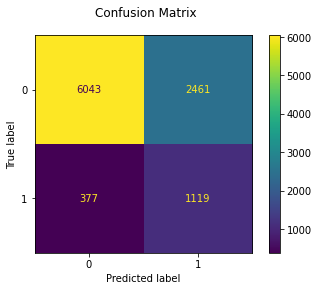

In [83]:
#https://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html#sphx-glr-auto-examples-classification-plot-digits-classification-py
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)
disp.figure_.suptitle("Confusion Matrix")
plt.show()